# Peaks extraction methods

This notebook illustrates the use of the *biotuner* toolbox with the aims to show that we can retrieve harmonic information from a generated signal using different peaks extraction methods

This notebook is one step towards the exploration of biological harmonies and their relevance for the carving of new musical systems, as compared to pseudo-random generative engines.

#### Retrieving frequency information from simulated signals using the biotuner

First, we will generate two signals composed of two sets of predetermined frequencies. The first one will contain harmonic frequencies, while the second will contain non-harmonic frequencies

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


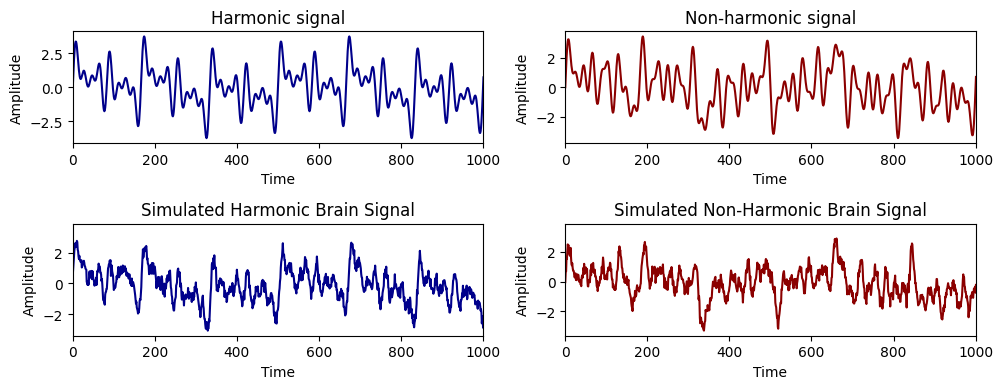

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from biotuner.biotuner_utils import generate_signal
!pip install neurodsp
from neurodsp.sim import sim_combined
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

sf = 1000
length =4
theta = 0
freqs_harm = [2, 6, 12, 18, 24, 36, 48]
freqs_noharm = [2, 5, 11, 17, 23, 33, 49]
# set amplitudes to random between 0.5 and 1
amps = np.random.uniform(0.5, 1, len(freqs_harm))
    
signal_harm = generate_signal(sf, length, freqs_harm, amps, show=False)
signal_noharm = generate_signal(sf, length, freqs_noharm, amps, show=False)

# Set up simulation parameters for neurodsp
n_seconds = 4
fs = 1000
components_harm = {
    'sim_powerlaw': {'exponent': -0.8}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs_harm]  # list of dictionaries
}
components_noharm = {
    'sim_powerlaw': {'exponent': -0.8}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs_noharm]  # list of dictionaries
}

# Each component (aperiodic & oscillatory) needs a variance
component_variances = [10 for _ in range(len(freqs_noharm) + 1)]  # +1 for the 'sim_powerlaw' component

# Simulate the signal
brain_signal_harm = sim_combined(n_seconds, fs, components_harm, component_variances)
brain_signal_noharm = sim_combined(n_seconds, fs, components_noharm, component_variances)

# plot the signals with 2 rows of subplots

fig, axs = plt.subplots(2, 2, figsize=(10, 4))  # Create 2x2 subplots

# First row: Simulated oscillations
axs[0, 0].plot(signal_harm, color='darkblue')
axs[0, 0].set_title('Harmonic signal')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].set_xlim(0, 1000)

axs[0, 1].plot(signal_noharm, color='darkred')
axs[0, 1].set_title('Non-harmonic signal')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Amplitude')
axs[0, 1].set_xlim(0, 1000)

# Second row: Simulated brain signals
axs[1, 0].plot(brain_signal_harm, color='darkblue')
axs[1, 0].set_title('Simulated Harmonic Brain Signal')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].set_xlim(0, 1000)

axs[1, 1].plot(brain_signal_noharm, color='darkred')
axs[1, 1].set_title('Simulated Non-Harmonic Brain Signal')
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Amplitude')
axs[1, 1].set_xlim(0, 1000)

plt.tight_layout()
plt.show()


Then, we want to retrieve the generator frequencies using different peaks_functions offered by the *biotuner*.

#### Peaks functions ([see the doc](https://github.com/AntoineBellemare/biotuner/blob/main/biotuner/biotuner_object.py))

**fixed** : ranges of frequency bands are fixed

**FOOOF** : peaks rising above the aperiodic component

**EMD**: Intrinsic Mode Functions (IMFs) are derived from Empirical Mode Decomposition (EMD)  
                   FFT is computed on each IMF 

**harmonic_recurrence**: keeps peaks for which a maximum of other peaks are harmonics

**EIMC**: keeps peaks for which a maximum of other peaks are intermodulation components 

### Fixed

And now with the **'fixed'** bands method. With the specified bands, we would expect to find *2, 6* and *24Hz* for the harmonic signal and *2, 5* and *23Hz* for the non-harmonic signal

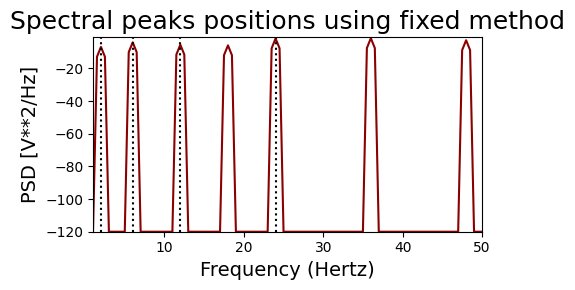

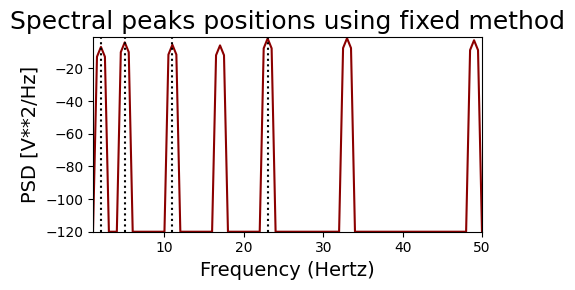

HARMONIC PEAKS 
RETRIEVED [ 2.  6. 12. 24.] ORIGINAL [2, 6, 12, 18, 24, 36, 48]
NON-HARMONIC PEAKS 
RETRIEVED [ 2.  5. 11. 23.] ORIGINAL [2, 5, 11, 17, 23, 33, 49]


In [2]:
from biotuner.biotuner_object import compute_biotuner
FREQ_BANDS = [[1, 3], [4, 7], [10, 20], [20, 30]]
# Initialize biotuner object for harmonic signal
bt_harm = compute_biotuner(sf=sf, peaks_function = 'fixed', precision = 0.5) 

# Extract spectral peaks
bt_harm.peaks_extraction(signal_harm, FREQ_BANDS = FREQ_BANDS, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 1000, graph=True)

# Initialize biotuner object for non-harmonic signal
bt_noharm = compute_biotuner(sf=sf, peaks_function = 'fixed', precision = 0.5) 

# Extract spectral peaks
bt_noharm.peaks_extraction(signal_noharm, FREQ_BANDS = FREQ_BANDS, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 1000, graph=True)

# Compare results
print('HARMONIC PEAKS', '\nRETRIEVED', bt_harm.peaks, 'ORIGINAL', freqs_harm)
print('NON-HARMONIC PEAKS', '\nRETRIEVED', bt_noharm.peaks, 'ORIGINAL', freqs_noharm)


### FOOOF

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 50 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                        -32.0322, -1.2705                                         
                                                                                                  
                                       7 peaks were found:                                        
          

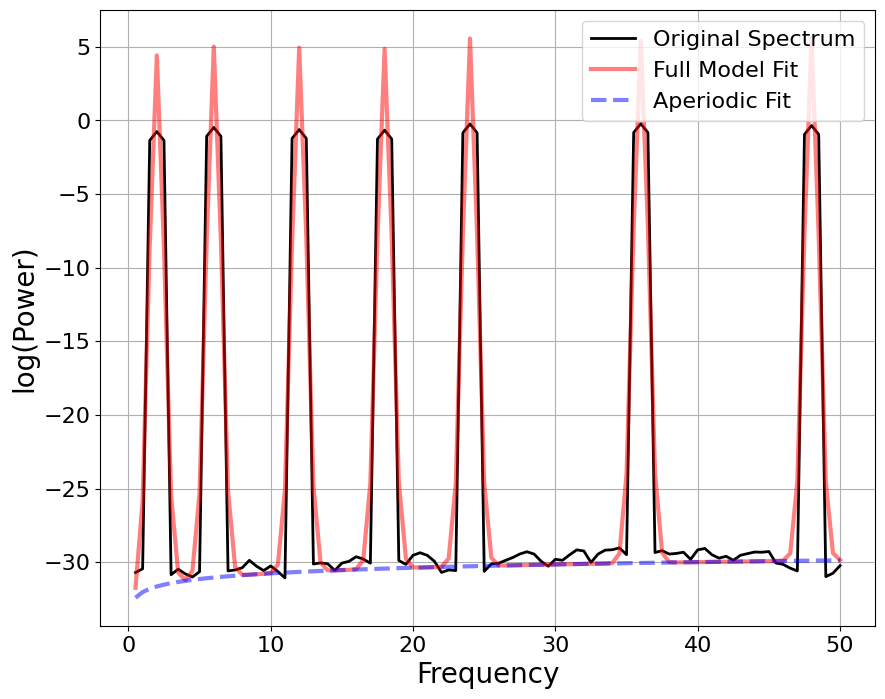

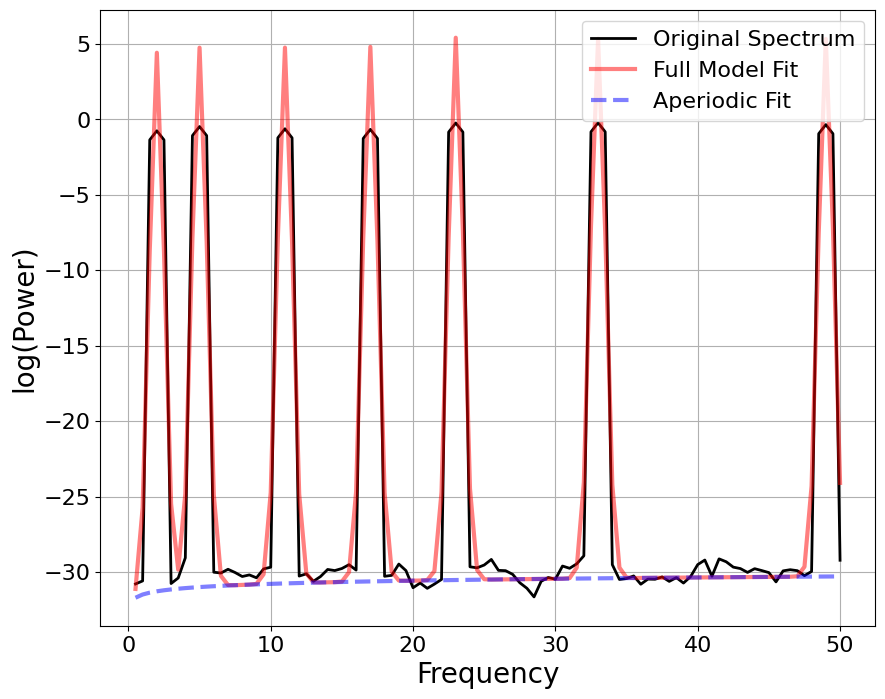

In [3]:
# Initialize biotuner object for harmonic signal
bt_harm = compute_biotuner(sf=sf, peaks_function = 'FOOOF', precision = 0.5) 

# Extract spectral peaks
bt_harm.peaks_extraction(signal_harm, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 1000, graph=True)

# Initialize biotuner object for non-harmonic signal
bt_noharm = compute_biotuner(sf=sf, peaks_function = 'FOOOF', precision = 0.5) 

# Extract spectral peaks
bt_noharm.peaks_extraction(signal_noharm, min_freq = 1, max_freq = 50, min_harms = 2, harm_limit = 1000, graph=True)

# Compare results
print('HARMONIC PEAKS', '\nRETRIEVED', bt_harm.peaks, 'ORIGINAL', freqs_harm)
print('NON-HARMONIC PEAKS', '\nRETRIEVED', bt_noharm.peaks, 'ORIGINAL', freqs_noharm)

### Empirical Mode Decomposition

In [4]:
# Initialize biotuner object for harmonic signal
bt_harm = compute_biotuner(sf=sf, peaks_function='EMD', precision=0.5) 

# Extract spectral peaks
bt_harm.peaks_extraction(signal_harm, min_freq=1, max_freq=50, nIMFs=3, prominence=10, rel_height=1, keep_first_IMF=True,
                         )

# Initialize biotuner object for non-harmonic signal
bt_noharm = compute_biotuner(sf=sf, peaks_function='EMD', precision=0.5) 

# Extract spectral peaks
bt_noharm.peaks_extraction(signal_noharm, min_freq=1, max_freq=50, nIMFs=3, prominence=10, rel_height=1, keep_first_IMF=True,
                           )

# Compare results
print('HARMONIC PEAKS', '\nRETRIEVED', bt_harm.peaks, 'ORIGINAL', freqs_harm)
print('NON-HARMONIC PEAKS', '\nRETRIEVED', bt_noharm.peaks, 'ORIGINAL', freqs_noharm)

HARMONIC PEAKS 
RETRIEVED [ 2.  6. 18. 36.] ORIGINAL [2, 6, 12, 18, 24, 36, 48]
NON-HARMONIC PEAKS 
RETRIEVED [ 5. 11. 23. 33.] ORIGINAL [2, 5, 11, 17, 23, 33, 49]


### Harmonic recurrence

This method identifies spectral peaks that have the highest recurrence in the spectrum based on their harmonic series.
In the graph, each colored line reprensent a spectral peak, while the associated dashed lines represent harmonics of this peak.


peaks [np.float64(2.0), np.float64(6.0), np.float64(12.0), np.float64(18.0), np.float64(24.0), np.float64(36.0), np.float64(48.0)]


<Figure size 500x200 with 0 Axes>

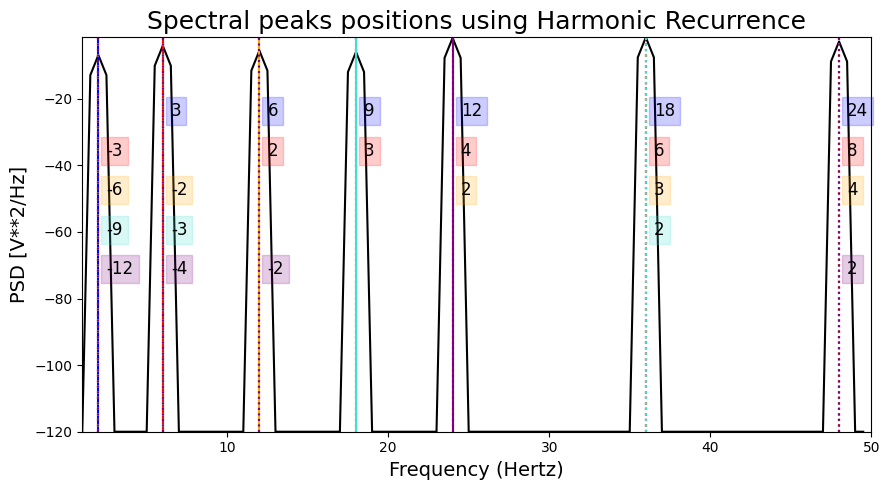

peaks [np.float64(1.4), np.float64(2.0), np.float64(2.6), np.float64(3.1), np.float64(3.9), np.float64(4.4), np.float64(5.0), np.float64(5.6), np.float64(6.1), np.float64(6.6), np.float64(7.1), np.float64(7.6), np.float64(8.4), np.float64(8.9), np.float64(9.4), np.float64(9.9), np.float64(10.4), np.float64(11.0), np.float64(11.6), np.float64(12.1), np.float64(12.6), np.float64(13.1), np.float64(13.6), np.float64(14.4), np.float64(14.9), np.float64(15.4), np.float64(15.9), np.float64(16.4), np.float64(17.0), np.float64(17.6), np.float64(18.1), np.float64(18.6), np.float64(19.1), np.float64(19.6), np.float64(20.4), np.float64(20.9), np.float64(21.4), np.float64(21.9), np.float64(22.4), np.float64(23.0), np.float64(23.6), np.float64(24.1), np.float64(24.6), np.float64(25.1), np.float64(25.6), np.float64(26.1), np.float64(26.6), np.float64(27.1), np.float64(27.6), np.float64(28.4), np.float64(28.9), np.float64(29.4), np.float64(29.9), np.float64(30.4), np.float64(30.9), np.float64(31.4), n

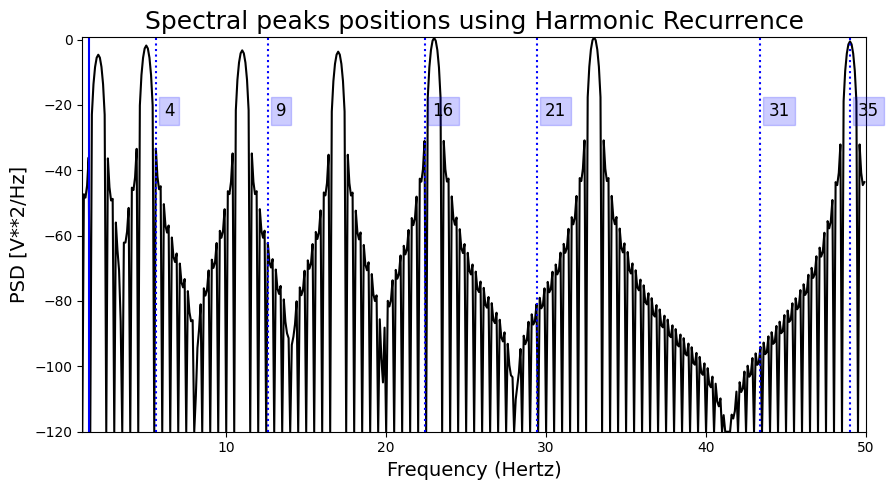

HARMONIC PEAKS 
RETRIEVED [ 6.  2. 12. 48.] ORIGINAL [2, 6, 12, 18, 24, 36, 48]
NON-HARMONIC PEAKS 
RETRIEVED [1.4] ORIGINAL [2, 5, 11, 17, 23, 33, 49]


In [8]:
# Initialize biotuner object for harmonic signal
bt_harm = compute_biotuner(sf=sf, peaks_function = 'harmonic_recurrence', precision = 0.5) 

#set figzise
plt.figure(figsize=(5, 2))
# Extract spectral peaks
bt_harm.peaks_extraction(signal_harm, min_freq=1, max_freq=50, min_harms=2, harm_limit=1000, graph=True,
                         prominence=15, rel_height=1, n_peaks=4)

# Initialize biotuner object for non-harmonic signal
bt_noharm = compute_biotuner(sf=sf, peaks_function='harmonic_recurrence', precision=0.1) 

# Extract spectral peaks
bt_noharm.peaks_extraction(signal_noharm, min_freq=1, max_freq=50, min_harms=5, harm_limit=1000, graph=True,
                           prominence=15, rel_height=1, n_peaks=4)

# Compare results
print('HARMONIC PEAKS', '\nRETRIEVED', bt_harm.peaks, 'ORIGINAL', freqs_harm)
print('NON-HARMONIC PEAKS', '\nRETRIEVED', bt_noharm.peaks, 'ORIGINAL', freqs_noharm)

### Endogeneous Inter-Modulation Components

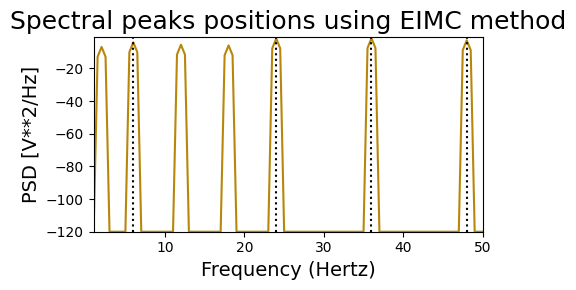

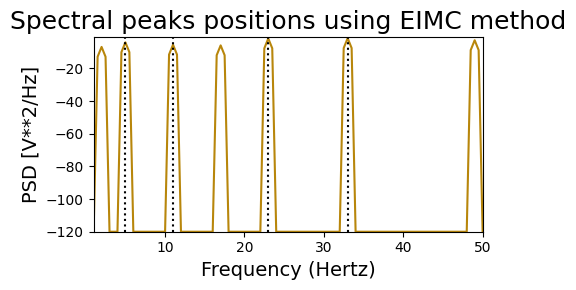

HARMONIC PEAKS 
RETRIEVED [36.0, 24.0, 48.0, 6.0] ORIGINAL [2, 6, 12, 18, 24, 36, 48]
NON-HARMONIC PEAKS 
RETRIEVED [33.0, 23.0, 5.0, 11.0] ORIGINAL [2, 5, 11, 17, 23, 33, 49]


In [9]:
# Initialize biotuner object for harmonic signal
bt_harm = compute_biotuner(sf=sf, peaks_function='EIMC', precision=0.5) 

# Extract spectral peaks
bt_harm.peaks_extraction(signal_harm, min_freq=1, max_freq=50,  graph=True,
                         n_peaks=4, prominence=10, rel_height=10)

# Initialize biotuner object for non-harmonic signal
bt_noharm = compute_biotuner(sf=sf, peaks_function='EIMC', precision=0.5) 

# Extract spectral peaks
bt_noharm.peaks_extraction(signal_noharm, min_freq=1, max_freq=50, graph=True,
                           n_peaks=4, prominence=10, rel_height=10)

# Round the peaks according to the precision, which is a float
bt_harm.peaks = [round(x * 2) / 2 for x in bt_harm.peaks]
bt_noharm.peaks = [round(x * 2) / 2 for x in bt_noharm.peaks]

# Compare results
print('HARMONIC PEAKS', '\nRETRIEVED', bt_harm.peaks, 'ORIGINAL', freqs_harm)
print('NON-HARMONIC PEAKS', '\nRETRIEVED', bt_noharm.peaks, 'ORIGINAL', freqs_noharm)

### Effect of noise on peaks detection

We will add noise to the signal to see how the algorithms perform

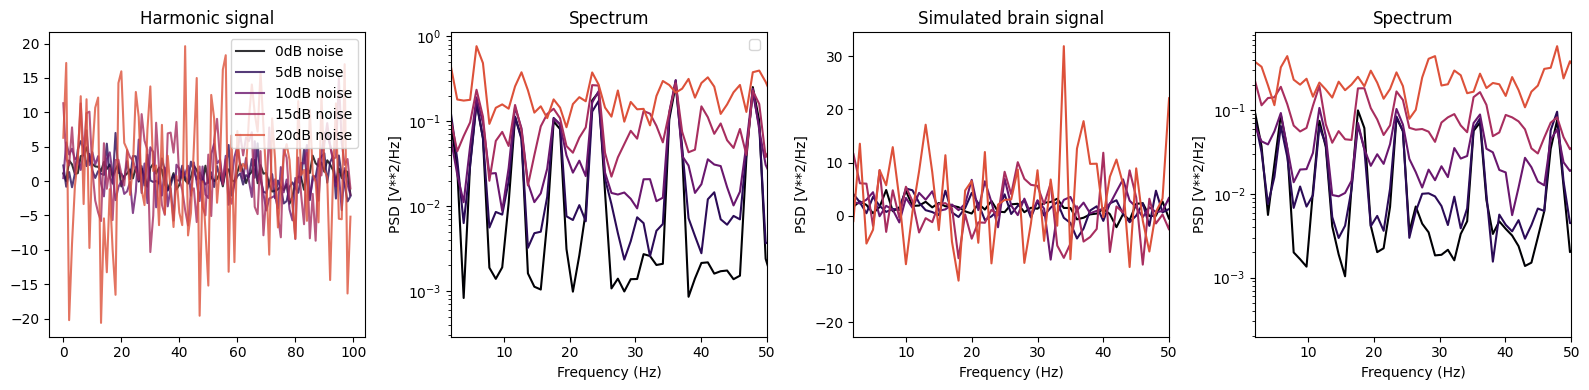

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Set a target channel noise power to something very noisy
noise_db_list = range(0, 25, 5)

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

colors = plt.cm.inferno(np.linspace(0, 0.6, len(noise_db_list)))

for i, db in enumerate(noise_db_list):
    # Convert to linear Watt units
    target_noise_watts = 10 ** (db / 10)

    # Generate noise samples
    mean_noise = 0
    noise_signal_harm = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal_harm))
    noise_signal_brain_harm = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(brain_signal_harm))

    # Noise up the original signal (oscillations and brain signals) and plot
    noised_signal_harm = signal_harm + noise_signal_harm
    noised_brain_signal_harm = brain_signal_harm + noise_signal_brain_harm
    
    # For harmonic oscillation
    axs[0].plot(noised_signal_harm[0:100], color = colors[i], label='{}dB noise'.format(db), alpha=0.8)
    freqs, psd = welch(noised_signal_harm, sf, nperseg=1024)
    axs[1].semilogy(freqs, psd, color = colors[i])
    
    # For simulated brain signal
    axs[2].plot(noised_brain_signal_harm[0:100], color = colors[i], alpha=1)
    freqs, psd = welch(noised_brain_signal_harm, sf, nperseg=1024)
    axs[3].semilogy(freqs, psd, color = colors[i])

# Set labels and titles
axs[0].set_title('Harmonic signal')
axs[1].set_title('Spectrum')
axs[2].set_title('Simulated brain signal')
axs[3].set_title('Spectrum')

for ax in axs[1:4]:
    ax.set_xlim([2, 50])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD [V**2/Hz]')

# Add legends
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


#### We will now quantify the effect of noise on peak detection by plotting the performance of the algorithms for different intensity of noise.

The first plot is for a signal made from a set of harmonic frequencies.

fixed
harmonic_recurrence
peaks [np.float64(2.0), np.float64(6.0), np.float64(12.0), np.float64(18.0), np.float64(24.0), np.float64(26.0), np.float64(36.0), np.float64(47.0), np.float64(61.0), np.float64(63.5), np.float64(68.0), np.float64(71.0), np.float64(74.0), np.float64(82.0), np.float64(91.5), np.float64(96.0), np.float64(102.0), np.float64(108.5), np.float64(116.5), np.float64(119.0), np.float64(123.5), np.float64(126.5), np.float64(131.5), np.float64(142.5), np.float64(147.5), np.float64(152.0), np.float64(159.5), np.float64(167.5), np.float64(169.5), np.float64(175.5), np.float64(183.5), np.float64(186.5), np.float64(190.0), np.float64(193.5), np.float64(198.0), np.float64(204.5), np.float64(208.5), np.float64(216.0), np.float64(230.0), np.float64(241.5), np.float64(244.5), np.float64(249.5), np.float64(255.5), np.float64(258.5), np.float64(269.5), np.float64(281.0), np.float64(286.0), np.float64(289.0), np.float64(294.5), np.float64(297.0), np.float64(309.5), np.float64(318.5

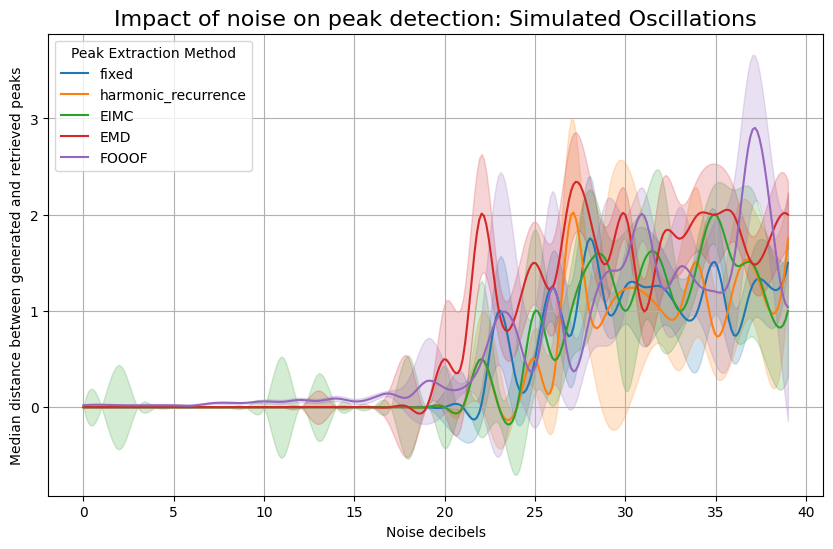

fixed
harmonic_recurrence
peaks [np.float64(2.0), np.float64(6.0), np.float64(12.0), np.float64(18.0), np.float64(24.0), np.float64(33.0), np.float64(35.5), np.float64(42.5), np.float64(51.0), np.float64(56.0), np.float64(64.0), np.float64(81.5), np.float64(83.5), np.float64(87.0), np.float64(89.5), np.float64(91.0), np.float64(98.5), np.float64(103.5), np.float64(116.5), np.float64(127.5), np.float64(134.5), np.float64(138.5), np.float64(142.5), np.float64(144.0), np.float64(153.5), np.float64(161.5), np.float64(163.5), np.float64(183.0), np.float64(191.5), np.float64(193.5), np.float64(201.5), np.float64(203.5), np.float64(210.5), np.float64(216.0), np.float64(219.5), np.float64(227.5), np.float64(241.5), np.float64(260.0), np.float64(270.0), np.float64(280.0), np.float64(283.5), np.float64(293.5), np.float64(300.5), np.float64(306.5), np.float64(313.0), np.float64(314.5), np.float64(319.0), np.float64(326.5), np.float64(330.0), np.float64(331.5), np.float64(340.0), np.float64(347.0)

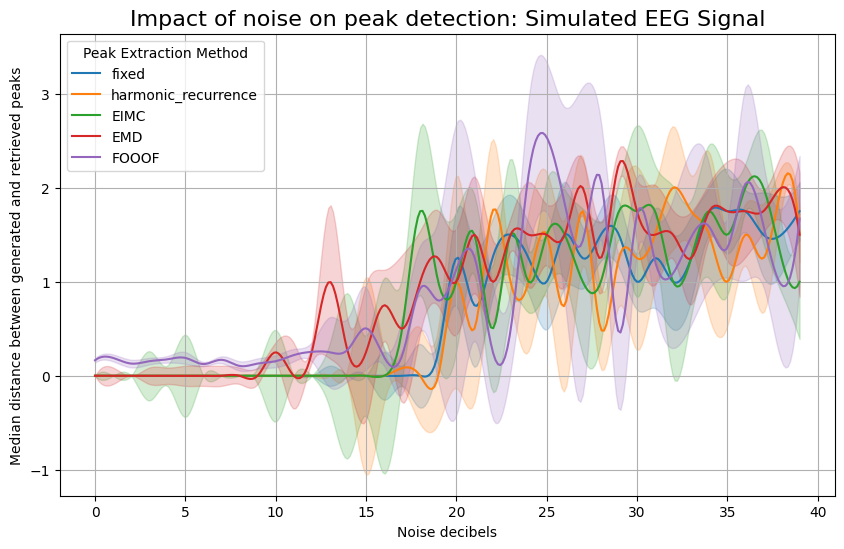

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined
from scipy.interpolate import make_interp_spline, BSpline

# Setting up parameters
sf = 1000
length = 4
n_times = 5 #number of times the bootstraping is executed
freqs = [2, 6, 12, 18, 24, 36]
amps = [1, 1, 1, 1, 1, 1]
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]

# Simulate the signals
components = {
    'sim_powerlaw': {'exponent': -1}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs]  # list of dictionaries
}
component_variances = [1 for _ in range(len(freqs) + 1)]  # +1 for the 'sim_powerlaw' component

# Simulate original signal
simulated_EEG = sim_combined(length, sf, components, component_variances)

# Simulate EEG signal
simulated_oscillations = generate_signal(sf, length, freqs, amps, show=False, color = 'turquoise')  # Assuming generate_signal is your custom function

signals = {'Simulated Oscillations': simulated_oscillations, 'Simulated EEG Signal': simulated_EEG}

for title, signal in signals.items():
    peaks_methods = ['fixed', 'harmonic_recurrence', 'EIMC', 'EMD', 'FOOOF']
    noise_db_list = range(0, 40, 1)
    colors = ['darkred', 'darkblue', 'darkorange', 'black', 'cyan', 'deeppink']

    data = []
    for method, color in zip(peaks_methods, colors):
        print(method)
        median_distance_tot = []
        for db in noise_db_list: 
            t = 0
            median_distance = []
            while t < n_times:
                # Convert to linear Watt units
                target_noise_watts = 10 ** (db / 10)

                # Generate noise samples
                mean_noise = 0
                noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))

                # Noise up the original signal
                noised_signal = signal + noise_signal
            
                # set dictionary of prominence and rel_height for each method
                prominences = {'fixed': 10, 'harmonic_recurrence': 8, 'EMD': 1, 'FOOOF': 10, 'HH1D_max': 1, 'EIMC': 7}
                rel_heights = {'fixed': 1, 'harmonic_recurrence': 1, 'EMD': 0.7, 'FOOOF': 1, 'HH1D_max': 1, 'EIMC': 1}
                # Initialize biotuner object
                biotuning = compute_biotuner(sf = sf, peaks_function=method, precision=0.5)
                
                if method == 'EMD':
                    biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                        FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                        rel_height=rel_heights[method], nIMFs=6, keep_first_IMF=False, n_peaks=5)
                    biotuning.peaks = biotuning.peaks[0:4] # select only the first 4 peaks
                    biotuning.peak = [x for x in biotuning.peaks if x <= freqs[-1]+1]
                    
                else:
                    try:
                        biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                            FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                            rel_height=rel_heights[method], nIMFs=3, keep_first_IMF=True, n_peaks=4)
                        biotuning.peaks = [x for x in biotuning.peaks if x <= freqs[-1]+1]
                    except:
                        biotuning.peaks = []
                if db == 0:
                    no_noise_peaks = biotuning.peaks
                if len(biotuning.peaks) == 0:
                    median_distance.append(np.nan)
                else:
                    list_distance = []
                    for p in biotuning.peaks:
                        takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
                        closest = takeClosest(p,freqs)
                        list_distance.append(abs(p-closest))   
                    median_distance.append(np.nanmedian(list_distance))
                t += 1
            median_distance_tot.append(np.nanmedian(median_distance)) 
            # calculate standard deviation
            std_dev = np.std(median_distance)
                    # Continue with your computations... 

            data.append([method, db, np.nanmedian(median_distance), np.std(median_distance)])

    df = pd.DataFrame(data, columns=["Method", "Noise decibels", "Median distance", "Std deviation"])

    # Add the option for std or 95% CI
    error_option = 'CI'  # change to 'std' for standard deviation

    plt.figure(figsize=(10,6))
    for method in peaks_methods:
        df_method = df[df["Method"] == method]
        df_method = df_method[df_method['Std deviation'].notna()]
        
        # To create smooth line plot
        xnew = np.linspace(df_method["Noise decibels"].min(), df_method["Noise decibels"].max(), 300)
        spl = make_interp_spline(df_method["Noise decibels"], df_method["Median distance"], k=3)  # type: BSpline
        y_smooth = spl(xnew)
        
        if error_option == 'std':
            spl_std = make_interp_spline(df_method["Noise decibels"], df_method["Std deviation"], k=3)  # type: BSpline
            error_smooth = spl_std(xnew)
        elif error_option == 'CI':
            confidence_interval = df_method["Std deviation"] / np.sqrt(n_times) * 1.96
            spl_ci = make_interp_spline(df_method["Noise decibels"], confidence_interval, k=3)  # type: BSpline
            error_smooth = spl_ci(xnew)

        line, = plt.plot(xnew, y_smooth, label=method)  # use same color for the line
        color = line.get_color()  # get color of the line

        plt.fill_between(xnew, y_smooth-error_smooth, y_smooth+error_smooth, color=color, alpha=0.2)

    plt.title(f'Impact of noise on peak detection: {title}', size=16)
    plt.grid(True)
    plt.legend(loc="upper left", title="Peak Extraction Method")
    plt.xlabel("Noise decibels")
    plt.ylabel("Median distance between generated and retrieved peaks")
    plt.show()
    plt.close()



fixed
harmonic_recurrence
peaks [np.float64(2.0), np.float64(6.5), np.float64(15.5), np.float64(18.5), np.float64(25.0), np.float64(39.0), np.float64(48.5), np.float64(56.5), np.float64(66.5), np.float64(75.0), np.float64(87.5), np.float64(92.5), np.float64(101.0), np.float64(110.0), np.float64(114.0), np.float64(122.0), np.float64(145.0), np.float64(153.5), np.float64(159.5), np.float64(167.0), np.float64(173.5), np.float64(178.5), np.float64(185.5), np.float64(187.5), np.float64(191.5), np.float64(197.5), np.float64(204.0), np.float64(212.0), np.float64(216.0), np.float64(227.5), np.float64(234.5), np.float64(237.0), np.float64(238.0), np.float64(247.5), np.float64(250.5), np.float64(259.5), np.float64(263.5), np.float64(270.0), np.float64(283.5), np.float64(296.5), np.float64(304.5), np.float64(307.5), np.float64(313.5), np.float64(317.5), np.float64(321.5), np.float64(329.0), np.float64(333.0), np.float64(339.5), np.float64(352.0), np.float64(357.5), np.float64(362.0), np.float64(3

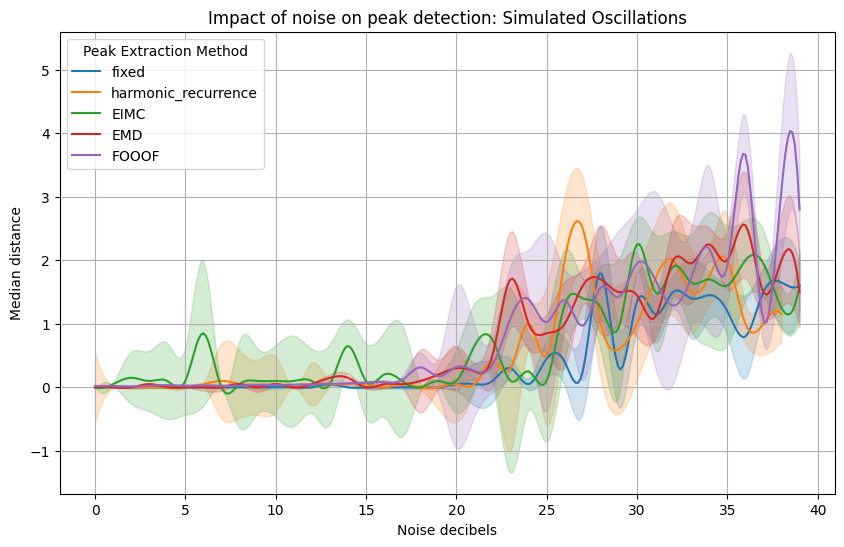

fixed
harmonic_recurrence
peaks [np.float64(2.0), np.float64(6.5), np.float64(15.5), np.float64(18.0), np.float64(24.5), np.float64(28.5), np.float64(35.5), np.float64(38.5), np.float64(46.5), np.float64(50.0), np.float64(59.0), np.float64(63.0), np.float64(67.5), np.float64(73.5), np.float64(79.5), np.float64(87.5), np.float64(99.5), np.float64(104.5), np.float64(108.0), np.float64(113.0), np.float64(117.0), np.float64(125.0), np.float64(139.0), np.float64(144.0), np.float64(155.5), np.float64(162.0), np.float64(167.0), np.float64(173.5), np.float64(176.5), np.float64(187.0), np.float64(196.5), np.float64(201.0), np.float64(210.0), np.float64(212.5), np.float64(214.5), np.float64(223.0), np.float64(225.0), np.float64(228.0), np.float64(238.0), np.float64(246.0), np.float64(250.5), np.float64(264.0), np.float64(271.5), np.float64(276.0), np.float64(279.5), np.float64(284.0), np.float64(296.0), np.float64(298.5), np.float64(303.0), np.float64(314.5), np.float64(321.0), np.float64(325.0)

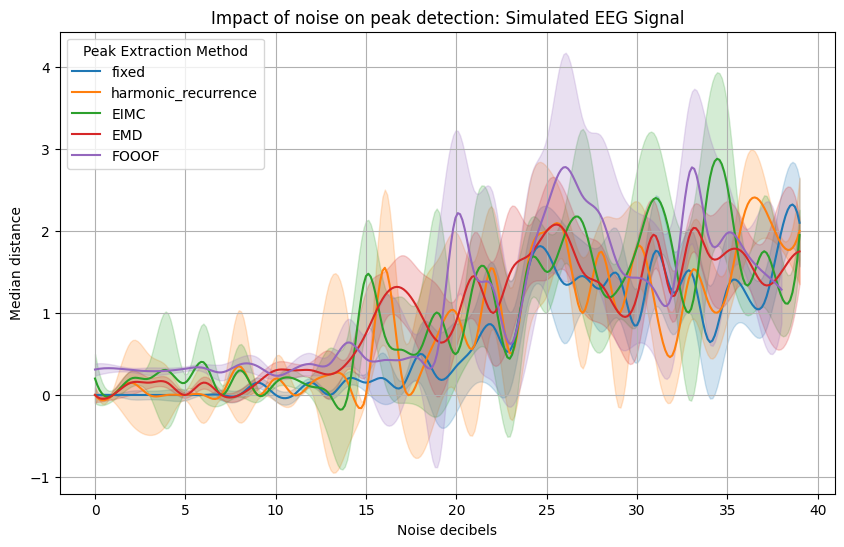

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from neurodsp.sim import sim_combined
from scipy.interpolate import make_interp_spline, BSpline

# Setting up parameters
sf = 1000
length = 4
n_times = 5 #number of times the bootstraping is executed
freqs = [2, 6.5, 15.5, 18.3, 24.9, 39.1]
amps = [1, 1, 1, 1, 1, 1]
FREQ_BANDS = [[1, 5], [5, 10], [10, 20], [20, 30]]

# Simulate the signals
components = {
    'sim_powerlaw': {'exponent': -1}, 
    'sim_oscillation': [{'freq': freq} for freq in freqs]  # list of dictionaries
}
component_variances = [1 for _ in range(len(freqs) + 1)]  # +1 for the 'sim_powerlaw' component

# Simulate original signal
simulated_EEG = sim_combined(length, sf, components, component_variances)

# Simulate EEG signal
simulated_oscillations = generate_signal(sf, length, freqs, amps, show=False, color = 'turquoise')  # Assuming generate_signal is your custom function

signals = {'Simulated Oscillations': simulated_oscillations, 'Simulated EEG Signal': simulated_EEG}

for title, signal in signals.items():
    peaks_methods = ['fixed', 'harmonic_recurrence', 'EIMC', 'EMD', 'FOOOF']
    noise_db_list = range(0, 40, 1)
    colors = ['darkred', 'darkblue', 'darkorange', 'black', 'cyan', 'deeppink']

    data = []
    for method, color in zip(peaks_methods, colors):
        print(method)
        median_distance_tot = []
        for db in noise_db_list: 
            t = 0
            median_distance = []
            while t < n_times:
                # Convert to linear Watt units
                target_noise_watts = 10 ** (db / 10)

                # Generate noise samples
                mean_noise = 0
                noise_signal = np.random.normal(mean_noise, np.sqrt(target_noise_watts), len(signal))

                # Noise up the original signal
                noised_signal = signal + noise_signal
            
                # set dictionary of prominence and rel_height for each method
                prominences = {'fixed': 10, 'harmonic_recurrence': 8, 'EMD': 1, 'FOOOF': 10, 'HH1D_max': 1, 'EIMC': 7}
                rel_heights = {'fixed': 1, 'harmonic_recurrence': 1, 'EMD': 0.7, 'FOOOF': 1, 'HH1D_max': 1, 'EIMC': 1}
                # Initialize biotuner object
                biotuning = compute_biotuner(sf = sf, peaks_function=method, precision=0.5)
                
                if method == 'EMD':
                    biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                        FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                        rel_height=rel_heights[method], nIMFs=6, keep_first_IMF=False, n_peaks=5)
                    biotuning.peaks = biotuning.peaks[0:4] # select only the first 4 peaks
                    biotuning.peak = [x for x in biotuning.peaks if x <= freqs[-1]+1]
                    
                else:
                    try:
                        biotuning.peaks_extraction(noised_signal, min_freq=1, max_freq=50, min_harms=2, harm_limit=128, 
                                            FREQ_BANDS = FREQ_BANDS, verbose=False, graph=False, prominence=prominences[method],
                                            rel_height=rel_heights[method], nIMFs=3, keep_first_IMF=True, n_peaks=4)
                        biotuning.peaks = [x for x in biotuning.peaks if x <= freqs[-1]+1]
                    except:
                        biotuning.peaks = []
                if db == 0:
                    no_noise_peaks = biotuning.peaks
                if len(biotuning.peaks) == 0:
                    median_distance.append(np.nan)
                else:
                    list_distance = []
                    for p in biotuning.peaks:
                        takeClosest = lambda num,collection:min(collection,key=lambda x:abs(x-num))
                        closest = takeClosest(p,freqs)
                        list_distance.append(abs(p-closest))   
                    median_distance.append(np.nanmedian(list_distance))
                t += 1
            median_distance_tot.append(np.nanmedian(median_distance)) 
            # calculate standard deviation
            std_dev = np.std(median_distance)
                    # Continue with your computations... 

            data.append([method, db, np.nanmedian(median_distance), np.std(median_distance)])

    df = pd.DataFrame(data, columns=["Method", "Noise decibels", "Median distance", "Std deviation"])

    # Add the option for std or 95% CI
    error_option = 'CI'  # change to 'std' for standard deviation

    plt.figure(figsize=(10,6))
    for method in peaks_methods:
        df_method = df[df["Method"] == method]
        df_method = df_method[df_method['Std deviation'].notna()]
        
        # To create smooth line plot
        xnew = np.linspace(df_method["Noise decibels"].min(), df_method["Noise decibels"].max(), 300)
        spl = make_interp_spline(df_method["Noise decibels"], df_method["Median distance"], k=3)  # type: BSpline
        y_smooth = spl(xnew)
        
        if error_option == 'std':
            spl_std = make_interp_spline(df_method["Noise decibels"], df_method["Std deviation"], k=3)  # type: BSpline
            error_smooth = spl_std(xnew)
        elif error_option == 'CI':
            confidence_interval = df_method["Std deviation"] / np.sqrt(n_times) * 1.96
            spl_ci = make_interp_spline(df_method["Noise decibels"], confidence_interval, k=3)  # type: BSpline
            error_smooth = spl_ci(xnew)

        line, = plt.plot(xnew, y_smooth, label=method)  # use same color for the line
        color = line.get_color()  # get color of the line

        plt.fill_between(xnew, y_smooth-error_smooth, y_smooth+error_smooth, color=color, alpha=0.2)

    plt.title(f'Impact of noise on peak detection: {title}')
    plt.grid(True)
    plt.legend(loc="upper left", title="Peak Extraction Method")
    plt.xlabel("Noise decibels")
    plt.ylabel("Median distance")
    plt.show()
    plt.close()



The second plot is for a signal made from a set of inharmonic frequencies.